# U16 financial features analysis

## 拿取資料

<AxesSubplot:xlabel='date'>

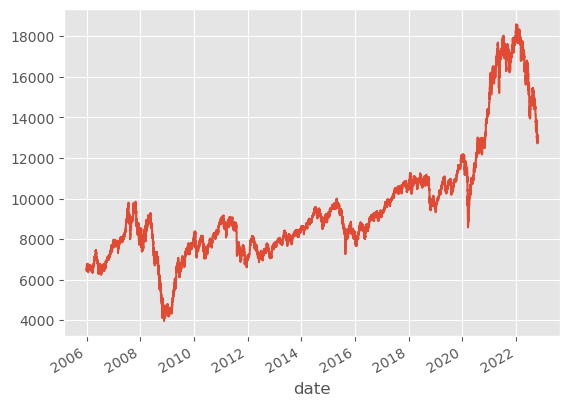

In [2]:
from finlab.data import Data
data = Data()

twii = data.get('發行量加權股價指數')
twii = twii['台股指數']
twii = twii[(twii.index.minute % 15 == 0)  & (twii.index.second == 0)]

import matplotlib.pyplot as plt
plt.style.use("ggplot")

twii.plot()

## 製作features

In [23]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

#    'ATR5': talib.ATR(twii, twii, twii, 5),
#    'ATR10': talib.ATR(twii, twii, twii, 10),
#    'ATR20': talib.ATR(twii, twii, twii, 20),
#    'ATR30': talib.ATR(twii, twii, twii, 30),
#    'ATR420': talib.ATR(twii, twii, twii, 420),    
    
    
    'return': twii.shift(-10) > twii,
})

feature_names = list(dataset.columns[:-1])

## 訓練

In [24]:
import lightgbm as lgb

dataset_train = dataset[:'2020']
dataset_test = dataset['2021':]

train = dataset_train[feature_names], dataset_train['return']
test = dataset_test[feature_names], dataset_test['return']

gbm = lgb.LGBMClassifier(colsample_bytree=0.6320148430111057, metric='None',
                         min_child_samples=467, min_child_weight=10.0, n_estimators=5000,
                         n_jobs=4, num_leaves=7, random_state=314, reg_alpha=100,
                         reg_lambda=20, subsample=0.5546887938364559)
                          #n_estimators=1000, random_state=5, learning_rate=0.05)
gbm.fit(*train)
gbm.score(*test)

0.5321903848459417

## 測試哪些feature重要

<AxesSubplot:xlabel='Value', ylabel='Feature'>

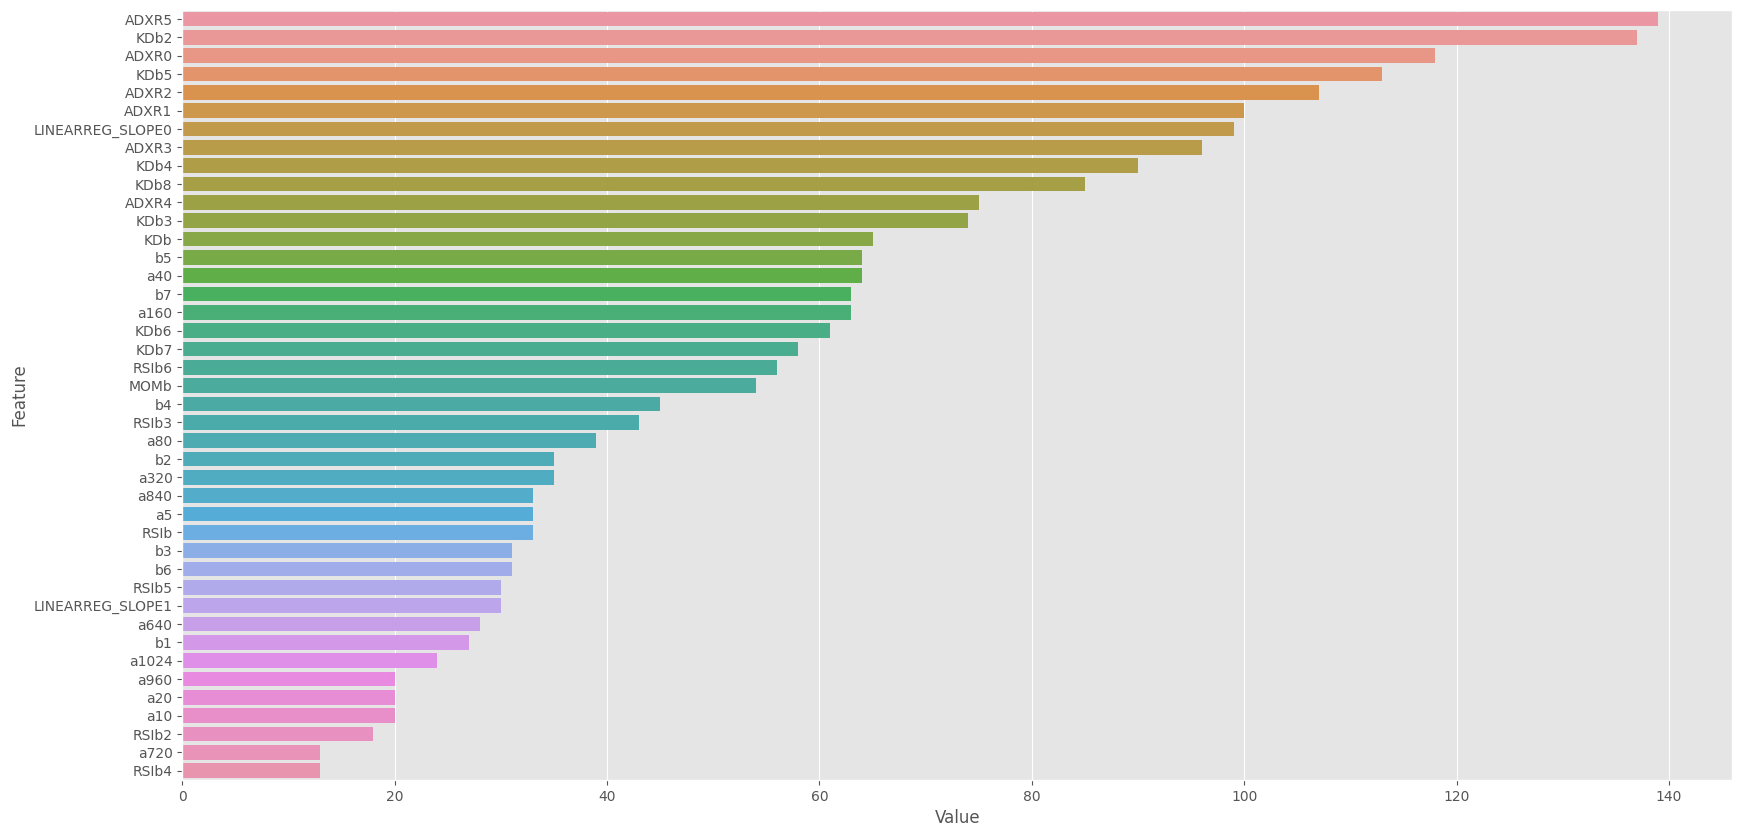

In [25]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,feature_names)), columns=['Value','Feature'])
feature_imp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

## 回測一下

<AxesSubplot:xlabel='date'>

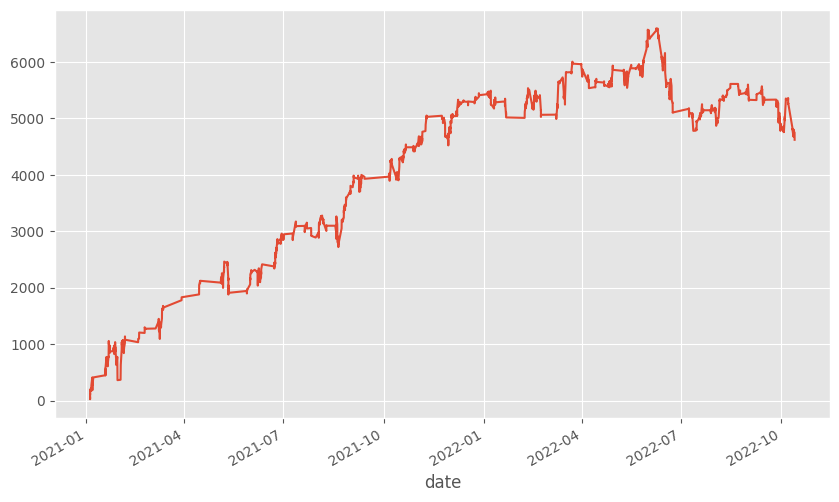

In [26]:
ey = gbm.predict_proba(dataset[feature_names])
ey = pd.Series(ey.swapaxes(0,1)[1], index=dataset.index)

eq = twii[dataset.index]
gain = ((eq.shift(-1) - eq))

signal = (ey > ey.quantile(0.7)).rolling(10).sum() > 0
eq = (gain[signal]['2021':]).cumsum()
eq.plot()

<AxesSubplot:>

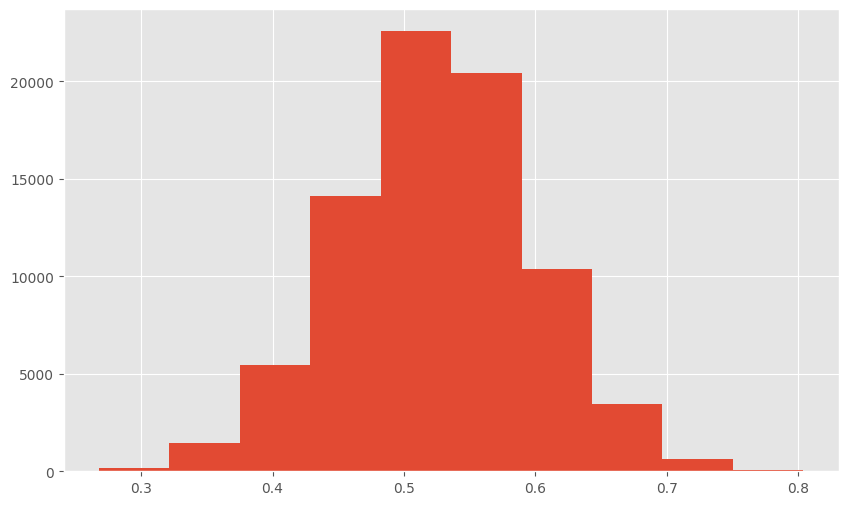

In [27]:
ey.hist()

## 手續費+滑價

In [28]:
signal['2016'].astype(int).diff().abs().sum()

129.0

# U17 Model Interpretation

## Recall and Precision

<AxesSubplot:>

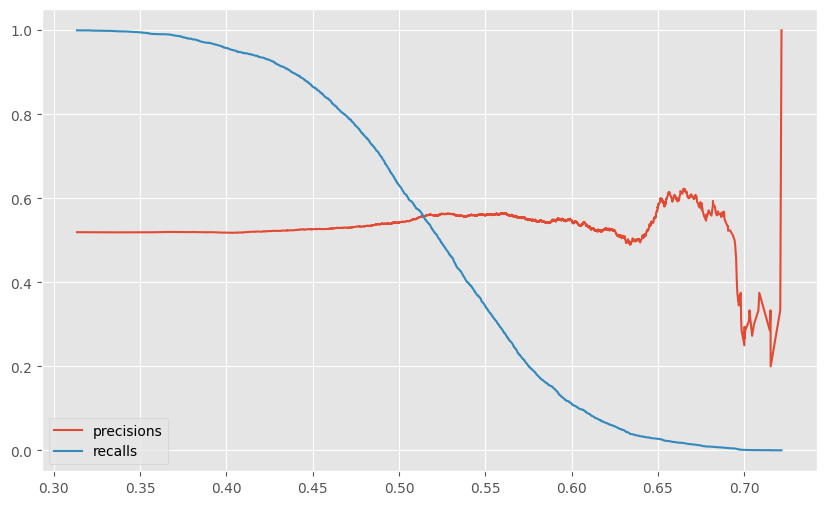

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(dataset['return']['2021':], ey['2021':])

pd.DataFrame({
    'precisions':precisions[:-1],
    'recalls':recalls[:-1],
}, index=thresholds).plot()


In [30]:
len(dataset['return']['2016':])

31597

## ROC Curve

(14931,)
(14931,)
(14931,)


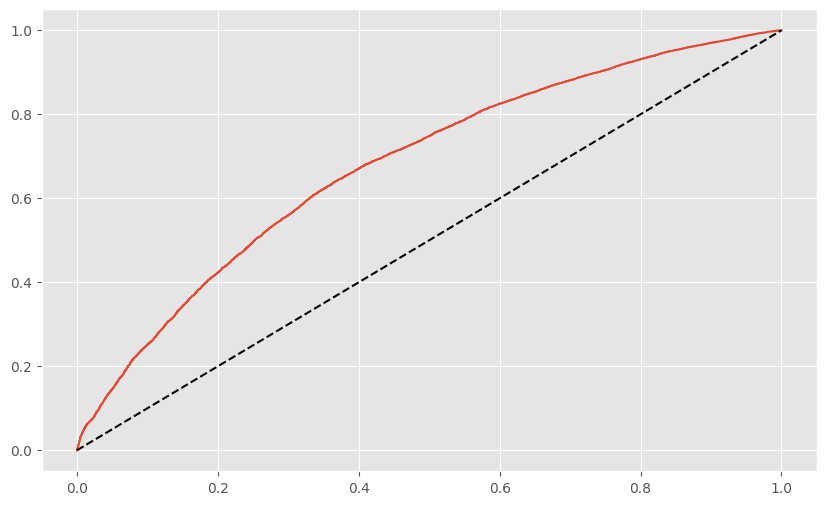

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(dataset['return']['2016':], ey['2016':])

print(fpr.shape)
print(tpr.shape)
print(thresholds.shape)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')

### 使用 eli5 察看機器學習如何做決定

In [32]:
import eli5

eli5.explain_prediction_lightgbm(gbm, dataset[feature_names].iloc[10])

Explanation(estimator="LGBMClassifier(colsample_bytree=0.6320148430111057, metric='None',\n               min_child_samples=467, min_child_weight=10.0, n_estimators=5000,\n               n_jobs=4, num_leaves=7, random_state=314, reg_alpha=100,\n               reg_lambda=20, subsample=0.5546887938364559)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=True, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='KDb5', weight=0.15954630993155774, std=None, value=nan), FeatureWeight(feature='LINEARREG_SLOPE0', weight=0.15878127605997056, std=None, value=nan), FeatureWeight(feature='b1', weight=0.13542530644145495, std=None, value=nan), FeatureWeight(feature='a40', weight=0.12953052332897622, std=None, value=nan), FeatureWeight(feature='a80', weight=0.12882435750516924, std=None, value=nan), FeatureWeight(feature='<BIAS>', weight=0.10825677963328899, std=None, value=1.0), FeatureWeight(feature='KDb6', weight=0.0850262225951302, std=None, value=nan), FeatureWeight(feature='ADXR4', weight=0.08160246257750896, std=None, value=nan), FeatureWeight(feature='KDb8', weight=0.08024719528626581, std=None, value=nan), FeatureWeight(feature='b2', weight=0.0660728221121831, std=None, value=nan), FeatureWeight(feature='MOMb', weight=0.06502560910575533, std=None, value=nan), FeatureWeight(feature='ADXR1', weight=0.0629654413114196, std=None, value=nan), FeatureWeight(feature='b7', weight=0.05796526360311301, std=None, value=nan), FeatureWeight(feature='a160', weight=0.05178745193573874, std=None, value=nan), FeatureWeight(feature='b3', weight=0.038303045607940844, std=None, value=nan), FeatureWeight(feature='b4', weight=0.036416192884202815, std=None, value=nan), FeatureWeight(feature='a5', weight=0.03595759688535047, std=None, value=0.9998637602179834), FeatureWeight(feature='ADXR0', weight=0.03472693054194324, std=None, value=nan), FeatureWeight(feature='RSIb', weight=0.02823456293910795, std=None, value=nan), FeatureWeight(feature='LINEARREG_SLOPE1', weight=0.022391373111186948, std=None, value=nan), FeatureWeight(feature='a720', weight=0.014935268276812729, std=None, value=nan), FeatureWeight(feature='a640', weight=0.010768608848996058, std=None, value=nan), FeatureWeight(feature='a10', weight=0.010069317254302561, std=None, value=1.0025177980671949), FeatureWeight(feature='a20', weight=0.006309817012325228, std=None, value=nan), FeatureWeight(feature='KDb7', weight=0.0053713825306356214, std=None, value=nan), FeatureWeight(feature='RSIb5', weight=0.0006863669934533954, std=None, value=nan)], neg=[FeatureWeight(feature='KDb2', weight=-0.11107693678999511, std=None, value=nan), FeatureWeight(feature='KDb4', weight=-0.08230473917792394, std=None, value=nan), FeatureWeight(feature='ADXR3', weight=-0.06130087353773295, std=None, value=nan), FeatureWeight(feature='ADXR5', weight=-0.06119938429605108, std

### 使用Skater來察看機器學習如何做實驗

In [33]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=dataset_test[feature_names].values, 
                             feature_names=feature_names)
im_model = InMemoryModel(gbm.predict_proba, examples=dataset_test[feature_names].values, 
                         target_names=['down', 'rise'])



In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True)

NameError: name 'interpreter' is not defined

#### 1. 挑幾項出來看

In [ ]:
r = interpreter.partial_dependence.plot_partial_dependence([('ADXR3', 'KDb2')], im_model, grid_resolution=10, 
                                                           grid_range=(0,1), n_samples=1000, n_jobs=1,
                                                           with_variance=False, figsize = (6, 4), )

#### 分析為何判定會漲？

In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(dataset_test[feature_names].values, feature_names=feature_names)

doc_num = 0
exp.explain_instance(dataset_test[feature_names].iloc[doc_num], gbm.predict_proba).show_in_notebook()


In [ ]:
doc_num = 0
print('Actual Label:', dataset_test['return'].iloc[doc_num])
print('Predicted Label:', gbm.predict_proba(dataset_test[feature_names])[0])
exp.explain_instance(dataset_test[feature_names].iloc[doc_num], gbm.predict_proba).show_in_notebook()


### SHAP 分析package

In [ ]:
import shap
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(dataset_test[feature_names])
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

In [ ]:
gbm.predict_proba(dataset_test[feature_names])[0]

In [ ]:
shap.initjs()

doc_id = 100
shap.force_plot(explainer.expected_value, 
                shap_values[doc_id,:],dataset_test[feature_names].iloc[doc_id,:])

In [ ]:

shap.force_plot(explainer.expected_value, 
                shap_values[::5,:], dataset_test[feature_names].iloc[::5,:])

In [ ]:
shap.summary_plot(shap_values, dataset_test[feature_names])


## 傳統策略研發

In [ ]:
def backtest(k1, k2, plot=False):
    
    k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=k1, slowk_period=k2, slowd_period=k2/2)
    buy = k2 > d2
    sell = k2 < d2

    hold = pd.Series(np.nan, index=twii.index)
    hold[buy] = 1
    hold[sell] = -1
    hold.ffill(inplace=True)

    if (hold == 1).sum() == 0:
        return 1
    
    returns = twii.shift(-1) - twii
    
    if plot:
        
        returns[hold == 1][:'2015'].cumsum().plot()
    
    return returns[hold == 1][:'2015'].cumsum().iloc[-1]
   

maxr = 0
for k1 in range(40, 100, 1):
    for k2 in range(40, 100, 1):
        if k1 <= k2:
            continue
        r = backtest(k1, k2)
        if r > maxr:
            print(r, k1, k2)
            maxr = r

In [ ]:
backtest(88, 56, True)